# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [10]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [13]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

In [14]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [15]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [16]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [17]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=1
def create_qnn():
    feature_map = ZFeatureMap(nq)
    ansatz = RealAmplitudes(nq, reps=1)
    qc = QuantumCircuit(nq)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [19]:
from qiskit_machine_learning.connectors import TorchConnector
from torch import cat, no_grad, manual_seed

In [20]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, nq)    
        self.qnn = TorchConnector(qnn4)
        #self.fc2 = nn.Linear(pow(2, nq), CFG.target_size)
        
        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        #x = self.fc2(x)
        
        return x

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [22]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    summary(model, (3, 224, 224))
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [23]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
========== training ==========


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
         Identity-10          [-1, 128, 56, 56]               0
             ReLU-11          [-1, 128, 56, 56]               0
         Identity-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          32,768
      BatchNorm2d-14          [-1, 256,

Epoch 1 - avg_train_loss: -0.7391  avg_val_loss: -0.7586  time: 47s
Epoch 1 - avg_train_loss: -0.7391  avg_val_loss: -0.7586  time: 47s
Epoch 1 - Accuracy: 0.8211963589076723
Epoch 1 - Accuracy: 0.8211963589076723
Epoch 1 - Save Best Score: 0.8212 Model
Epoch 1 - Save Best Score: 0.8212 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.4841(-0.7586) 
Epoch: [2][1/192] Data 0.231 (0.231) Elapsed 0m 0s (remain 1m 48s) Loss: -0.8257(-0.8257) Grad: 14.0849  
Epoch: [2][101/192] Data 0.000 (0.003) Elapsed 0m 23s (remain 0m 21s) Loss: -0.8927(-0.7917) Grad: 3.4321  
Epoch: [2][192/192] Data 0.000 (0.001) Elapsed 0m 46s (remain 0m 0s) Loss: -0.7587(-0.7981) Grad: 13.6397  
EVAL: [1/49] Data 0.129 (0.129) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8129(-0.8129) 


Epoch 2 - avg_train_loss: -0.7981  avg_val_loss: -0.7990  time: 49s
Epoch 2 - avg_train_loss: -0.7981  avg_val_loss: -0.7990  time: 49s
Epoch 2 - Accuracy: 0.8504551365409623
Epoch 2 - Accuracy: 0.8504551365409623
Epoch 2 - Save Best Score: 0.8505 Model
Epoch 2 - Save Best Score: 0.8505 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.4965(-0.7990) 
Epoch: [3][1/192] Data 0.336 (0.336) Elapsed 0m 0s (remain 1m 55s) Loss: -0.8078(-0.8078) Grad: 25.9614  
Epoch: [3][101/192] Data 0.000 (0.004) Elapsed 0m 22s (remain 0m 20s) Loss: -0.9057(-0.8132) Grad: 7.1561  
Epoch: [3][192/192] Data 0.000 (0.002) Elapsed 0m 42s (remain 0m 0s) Loss: -0.7625(-0.8184) Grad: 6.4385  
EVAL: [1/49] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8385(-0.8385) 


Epoch 3 - avg_train_loss: -0.8184  avg_val_loss: -0.8219  time: 45s
Epoch 3 - avg_train_loss: -0.8184  avg_val_loss: -0.8219  time: 45s
Epoch 3 - Accuracy: 0.8602080624187256
Epoch 3 - Accuracy: 0.8602080624187256
Epoch 3 - Save Best Score: 0.8602 Model
Epoch 3 - Save Best Score: 0.8602 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5168(-0.8219) 
Epoch: [4][1/192] Data 0.285 (0.285) Elapsed 0m 0s (remain 1m 56s) Loss: -0.8271(-0.8271) Grad: 22.5187  
Epoch: [4][101/192] Data 0.000 (0.003) Elapsed 0m 23s (remain 0m 21s) Loss: -0.9012(-0.8274) Grad: 5.2092  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 0m 43s (remain 0m 0s) Loss: -0.7796(-0.8310) Grad: 4.9106  
EVAL: [1/49] Data 0.129 (0.129) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8282(-0.8282) 


Epoch 4 - avg_train_loss: -0.8310  avg_val_loss: -0.8126  time: 46s
Epoch 4 - avg_train_loss: -0.8310  avg_val_loss: -0.8126  time: 46s
Epoch 4 - Accuracy: 0.8686605981794538
Epoch 4 - Accuracy: 0.8686605981794538
Epoch 4 - Save Best Score: 0.8687 Model
Epoch 4 - Save Best Score: 0.8687 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5258(-0.8126) 
Epoch: [5][1/192] Data 0.335 (0.335) Elapsed 0m 0s (remain 2m 5s) Loss: -0.8430(-0.8430) Grad: 22.3820  
Epoch: [5][101/192] Data 0.000 (0.004) Elapsed 0m 24s (remain 0m 21s) Loss: -0.9050(-0.8372) Grad: 6.8659  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 0m 46s (remain 0m 0s) Loss: -0.7924(-0.8423) Grad: 4.0926  
EVAL: [1/49] Data 0.175 (0.175) Elapsed 0m 0s (remain 0m 13s) Loss: -0.8406(-0.8406) 


Epoch 5 - avg_train_loss: -0.8423  avg_val_loss: -0.8243  time: 50s
Epoch 5 - avg_train_loss: -0.8423  avg_val_loss: -0.8243  time: 50s
Epoch 5 - Accuracy: 0.871261378413524
Epoch 5 - Accuracy: 0.871261378413524
Epoch 5 - Save Best Score: 0.8713 Model
Epoch 5 - Save Best Score: 0.8713 Model


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 3s (remain 0m 0s) Loss: -0.5538(-0.8243) 
Epoch: [6][1/192] Data 0.346 (0.346) Elapsed 0m 0s (remain 2m 13s) Loss: -0.8553(-0.8553) Grad: 26.2152  
Epoch: [6][101/192] Data 0.000 (0.004) Elapsed 0m 27s (remain 0m 25s) Loss: -0.9094(-0.8444) Grad: 9.2274  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 0m 49s (remain 0m 0s) Loss: -0.7920(-0.8492) Grad: 2.7786  
EVAL: [1/49] Data 0.167 (0.167) Elapsed 0m 0s (remain 0m 11s) Loss: -0.8370(-0.8370) 


Epoch 6 - avg_train_loss: -0.8492  avg_val_loss: -0.8338  time: 53s
Epoch 6 - avg_train_loss: -0.8492  avg_val_loss: -0.8338  time: 53s
Epoch 6 - Accuracy: 0.8790637191157347
Epoch 6 - Accuracy: 0.8790637191157347
Epoch 6 - Save Best Score: 0.8791 Model
Epoch 6 - Save Best Score: 0.8791 Model


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 3s (remain 0m 0s) Loss: -0.5700(-0.8338) 
Epoch: [7][1/192] Data 0.372 (0.372) Elapsed 0m 0s (remain 2m 36s) Loss: -0.8722(-0.8722) Grad: 27.8993  
Epoch: [7][101/192] Data 0.000 (0.004) Elapsed 0m 25s (remain 0m 22s) Loss: -0.9124(-0.8524) Grad: 10.0060  
Epoch: [7][192/192] Data 0.000 (0.002) Elapsed 0m 47s (remain 0m 0s) Loss: -0.8035(-0.8561) Grad: 3.3763  
EVAL: [1/49] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8191(-0.8191) 


Epoch 7 - avg_train_loss: -0.8561  avg_val_loss: -0.8395  time: 50s
Epoch 7 - avg_train_loss: -0.8561  avg_val_loss: -0.8395  time: 50s
Epoch 7 - Accuracy: 0.8777633289986996
Epoch 7 - Accuracy: 0.8777633289986996


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5525(-0.8395) 
Epoch: [8][1/192] Data 0.307 (0.307) Elapsed 0m 0s (remain 2m 1s) Loss: -0.8552(-0.8552) Grad: 28.0825  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.9101(-0.8551) Grad: 8.4544  
Epoch: [8][192/192] Data 0.000 (0.002) Elapsed 0m 45s (remain 0m 0s) Loss: -0.8012(-0.8593) Grad: 4.9582  
EVAL: [1/49] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8325(-0.8325) 


Epoch 8 - avg_train_loss: -0.8593  avg_val_loss: -0.8411  time: 49s
Epoch 8 - avg_train_loss: -0.8593  avg_val_loss: -0.8411  time: 49s
Epoch 8 - Accuracy: 0.8777633289986996
Epoch 8 - Accuracy: 0.8777633289986996


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5438(-0.8411) 
Epoch: [9][1/192] Data 0.287 (0.287) Elapsed 0m 0s (remain 1m 55s) Loss: -0.8728(-0.8728) Grad: 25.2717  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 21s) Loss: -0.9122(-0.8598) Grad: 4.4895  
Epoch: [9][192/192] Data 0.000 (0.002) Elapsed 0m 45s (remain 0m 0s) Loss: -0.8119(-0.8634) Grad: 10.3194  
EVAL: [1/49] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 11s) Loss: -0.8449(-0.8449) 


Epoch 9 - avg_train_loss: -0.8634  avg_val_loss: -0.8422  time: 49s
Epoch 9 - avg_train_loss: -0.8634  avg_val_loss: -0.8422  time: 49s
Epoch 9 - Accuracy: 0.8745123537061118
Epoch 9 - Accuracy: 0.8745123537061118


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 3s (remain 0m 0s) Loss: -0.5181(-0.8422) 
Epoch: [10][1/192] Data 0.330 (0.330) Elapsed 0m 0s (remain 2m 7s) Loss: -0.8912(-0.8912) Grad: 20.2623  
Epoch: [10][101/192] Data 0.000 (0.004) Elapsed 0m 24s (remain 0m 22s) Loss: -0.9124(-0.8618) Grad: 1.5980  
Epoch: [10][192/192] Data 0.000 (0.002) Elapsed 0m 45s (remain 0m 0s) Loss: -0.7975(-0.8653) Grad: 10.9374  
EVAL: [1/49] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8410(-0.8410) 


Epoch 10 - avg_train_loss: -0.8653  avg_val_loss: -0.8429  time: 49s
Epoch 10 - avg_train_loss: -0.8653  avg_val_loss: -0.8429  time: 49s
Epoch 10 - Accuracy: 0.8745123537061118
Epoch 10 - Accuracy: 0.8745123537061118
========== CV ==========
========== CV ==========
Score: 0.87906
Score: 0.87906


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5237(-0.8429) 
TN 1119
FP 32
FN 154
TP 233


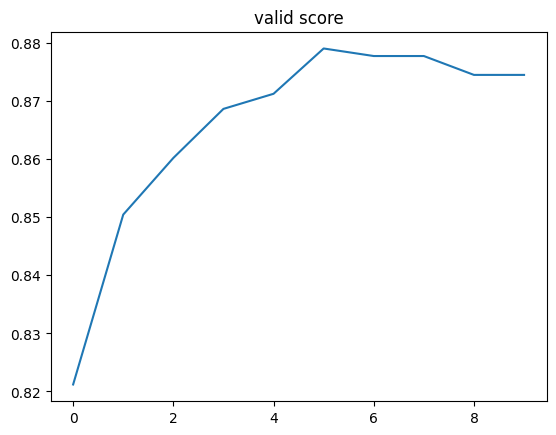

In [24]:
if __name__ == '__main__':
    main(0)